In [3]:
"Read a graph in gfa format and compute some stats"
from typing import Union
from pathlib import Path
from collections import Counter

class GFAStats:

    def __call__(self, path_gfa: Union[str,Path]):
        nodes, edges = self.get_nodes_edges(path_gfa)
        lens = [len(label) for label in nodes.values()]
        return lens
        
    def get_nodes_edges(self, path_gfa):
        nodes = dict()
        edges = list()
        with open(path_gfa, "r") as fp:
            for line in fp.readlines():
                line = line.replace("\n","")
                line_split = line.split("\t")
                
                # nodes
                if line_split[0] == "S": 
                    id_node = line_split[1]
                    label   = line_split[2]
                    nodes[id_node] = label
                # edges
                elif line_split[0] == "P":
                    _, idnode1, _, idnode2, _, _ = line_split
                    edges.append((idnode1,idnode2))
        return nodes, edges

    def length_graph(self, nodes):
        return sum(nodes.values())

    # dead ends: nodes with no in/outcoming edges

In [4]:
name_msa = "GC00004574"
PATH_GFA=f"/home/avila/pangeblocks/experiment/gfa/{name_msa}.gfa"
gfa_prg = f"../experiment/output-pandora/{name_msa}.gfa"
gfa_pb  = f"../experiment/gfa/{name_msa}.gfa"
# path_gfa_pggb = f"../experiment/output-pggb/GC00002971_r1_r1_1.fa.gz.f38ac34.417fcdf.5180c7d.smooth.final.gfa"

gfastats = GFAStats()

lens_pandora = gfastats(path_gfa=gfa_prg)
lens_pangeblocks = gfastats(path_gfa=gfa_pb)

In [6]:
print(f"Nodes Pandora: {len(lens_pandora)}")
print(f"Nodes Pangeblocs: {len(lens_pangeblocks)}")

Nodes Pandora: 31
Nodes Pangeblocs: 84


In [7]:
import seaborn as sns

<AxesSubplot: ylabel='Count'>

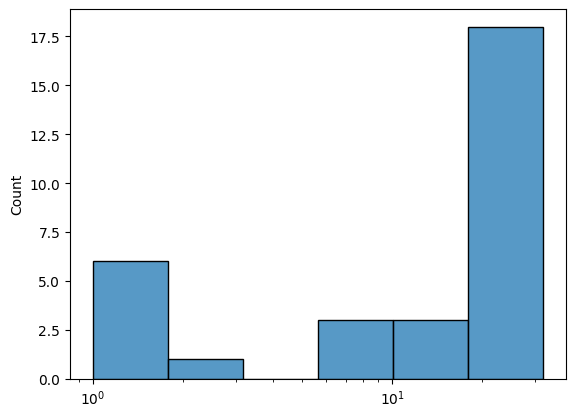

In [8]:
sns.histplot(lens_pandora, log_scale=True)

<AxesSubplot: ylabel='Count'>

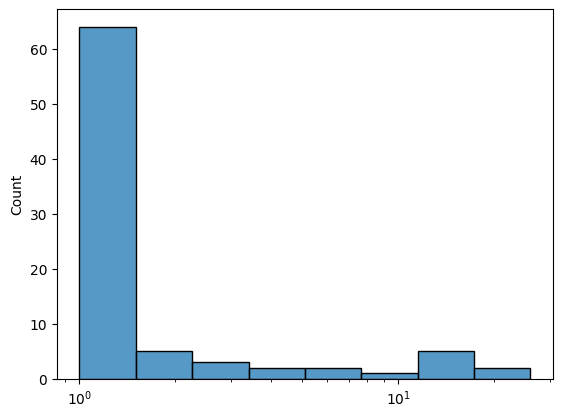

In [11]:
sns.histplot(lens_pangeblocks, log_scale=True)

In [12]:
import pandas as pd
pd.DataFrame({"lens_pandora": lens_pandora}).describe()

,lens_pandora
count,31.000000
mean,14.193548
std,8.934649
min,1.000000
25%,6.000000
50%,18.000000
75%,21.000000
max,32.000000


In [15]:
pd.DataFrame({"lens_pangeblocks": lens_pangeblocks}).describe()

,lens_pangeblocks
count,84.000000
mean,2.690476
std,4.562752
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,26.000000
